# Recommender system tutorial

## 1. Download the MovieLens 1M data set

The MovieLens 1M data set [1] dates from 2003 and contains about 1M movie ratings given by about 6k users to 4k movies. Smaller, larger, and more recent data sets are also available, but we'll go with the 1M data set in this tutorial because it's large enough that it represents a challenge and at the same time not too large to comfortably handle on a laptop.

[1] http://grouplens.org/datasets/movielens/

In [1]:
# Download the `MovieLens 1M` data set with 1M movie ratings to the current directory.
# Alternatively, try the `ml-latest-small.zip` for a smaller data set of 100k ratings.
from urllib.request import urlretrieve
url = 'http://files.grouplens.org/datasets/movielens/'
filename = 'ml-1m.zip'
urlretrieve(url + filename, filename);

Both the 100k and 1M data sets are zip files containing csv-like tables. Unfortunately, the 1M data set is provided in a less standard format, and requires a bit of parsing before we can hand it off to `pandas` for reading.

The MovieLens data sets contain movie ratings, but also information about users such as their occupation and age group, and information about movies such as their genre. Although this is interesting information to improve our recommender system with, we will stick to the movie ratings for now.

The movie ratings are given in long form, meaning that every observation or row represents one rating given by a particular user to a particular movie. We're also given the timestamp the rating was made, which may also help improve our model later on.

In [2]:
# Read the movie ratings from the zip file.
import pandas as pd
from zipfile import ZipFile
from io import StringIO
filename = 'ml-1m.zip'
with ZipFile(filename, 'r') as ml:
    if 'small' in filename:
        csv = filename.replace('.zip', '') + '/ratings.csv'
        df = pd.read_csv(ml.open(csv))
    elif '1m' in filename:
        csv = filename.replace('.zip', '') + '/ratings.dat'
        with ml.open(csv) as csv:
            data = ''.join(map(lambda line: line.decode('utf-8'), csv.readlines()))
            df = pd.read_csv(StringIO(data), sep='::', engine='python',
                             header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
df.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 2. Preprocess the data set

Each row specifies a `userId` and a `movieId`, which are unique identifiers for users and movies, respectively. However, these ids do not necessarily start at zero or end at the number of users or movies. As a preprocessing step, we'll translate the user and movie ids to zero-based consecutive user and movie indices. To do this, we simply use `pandas` to convert these columns to a categorical data type, and then use the category indices as user and movie indices.

In [3]:
# Convert the `userId` and `movieId` columns to categorical.
df.userId = df.userId.astype('category')
df.movieId = df.movieId.astype('category')
df.dtypes

userId       category
movieId      category
rating          int64
timestamp       int64
dtype: object

In [4]:
# The `userId` and `movieId` columns may contain non-consecutive numbers.
# Here, we add the category codes to the DataFrame as a zero-based consecutive version of these ids.
df['userIndex'] = df.userId.cat.codes
df['movieIndex'] = df.movieId.cat.codes
df.head()

,userId,movieId,rating,timestamp,userIndex,movieIndex
0,1,1193,5,978300760,0,1104
1,1,661,3,978302109,0,639
2,1,914,3,978301968,0,853
3,1,3408,4,978300275,0,3177
4,1,2355,5,978824291,0,2162


## 3. Split the data set into train, validation and test

Now that we're happy with our data set, we should split it into:

- a training set for optimizing our model's parameters,
- a validation set for optimizing our model's hyperparameters (such as the number of iterations and amount of regularization), and
- a test set for estimating the generalization performance of the resulting model.

We use `sklearn`'s `train_test_split` twice to split the data set into 80%-10%-10%. With 1M ratings, a validation and test sample of 10%, or 100k ratings, should be large enough to estimate the performance. Using more than 100k ratings will not substantially reduce the variance of our performance estimate, and allocating as much as we can to the training set will help us find a better solution.

Each data set consists of a feature matrix (prefixed by an uppercase `X`) and a vector of labels (prefixed by a lowercase `y`). The feature matrices only contain two features: the user index and the movie index. The labels contain the corresponding movie ratings. The indices in the feature matrices are not really features in the traditional sense of word, as their values are not directly related to the labels, but rather point to entities with a state that does influence the ratings.

In [5]:
try:
    from sklearn.model_selection import train_test_split  # sklearn 0.18+
except:
    from sklearn.cross_validation import train_test_split

n_users, n_movies = df.userIndex.max() + 1, df.movieIndex.max() + 1
X_train, X_test, y_train, y_test = train_test_split(
    df[['userIndex', 'movieIndex']].values,
    df['rating'].values,
    test_size=0.2,
    random_state=0)
X_validation, X_test, y_validation, y_test = train_test_split(
    X_test,
    y_test,
    test_size=0.5,
    random_state=0)

print('There are {n_users} users and {n_movies} movies in the data set.'.format(n_users=n_users, n_movies=n_movies))
print('The training, validation, and testing indices are of size {train_shape}, {validation_shape} and {test_shape}, respectively.'.format(
    train_shape=X_train.shape, validation_shape=X_validation.shape, test_shape=X_test.shape))
print('The labels (ratings) vary between {y_min} and {y_max}.'.format(y_min=y_train.min(), y_max=y_train.max()))

There are 6040 users and 3706 movies in the data set.
The training, validation, and testing indices are of size (800167, 2), (100021, 2) and (100021, 2), respectively.
The labels (ratings) vary between 1 and 5.


## 4. Set up a low-rank approximation model

### 4.1 Introduction to Collaborative Filtering

Arguably the single best performing model in the Netflix Prize [1] is a class of collaborative filtering (CF) models called low-rank approximation (LRA), sometimes also called matrix factorization (MF). CF models such as LRA exploit the collection of user preferences (collaboration) to make item recommendations to the users (filtering). Not all recommender systems are based on CF, and a CF model does not need to be based on LRA or MF. For instance, another type of recommender system may exploit similarities between users or items to make recommendations.

LRA is not just one model, but a class of models centered around a core idea. The most basic form of LRA can be improved upon substantially by incorporating time, user features, item features, and adjusting for user and item biases, among others.

[1] https://en.wikipedia.org/wiki/Netflix_Prize

### 4.2 The LRA model

A basic LRA model predicts the rating $r_{u,i} \in [0,\, 5]$ a user $u \in [1,\, N]$ would give to an item $i \in [1,\, M]$ as:

$$
\begin{align}
    \hat{r}_{u,i} = \sum_{k=1}^K a_{u,k} \cdot b_{i,k} = \mathbf{a}_u \cdot \mathbf{b}_i
\end{align}
$$

where $\mathbf{a}_u$ and $\mathbf{b}_i$ are two feature vectors of length $K$ describing the user $u$ and item $i$, respectively. As an example, let's say $K = 2$, then $r_{u,i} = a_{u,1} \cdot b_{i,1} + a_{u,2} \cdot b_{i,2}$. One way to interpret this model is to think of $b_{i,1}$ and $b_{i,2}$ as two numbers that describe the content of item $i$, such as the level of comedy or the movie's budget. Similarly, a user could be described by two numbers $a_{u,1}$ and $a_{u,2}$ that express that user's preference for comedic and high-budget movies. The rating user $u$ is predicted to give to item $i$ is then simply comedy content times comedy preference plus budget times budget preference. In practice, a user may take multiple such factors into consideration to arrive at a movie rating, and so it is probably reasonable to assume that $K$ should be larger than 5, but likely less than 1000.

If we organize all the user feature vectors $\mathbf{a}_u$ as rows into a matrix $A$, and all the item feature vectors $\mathbf{b}_i$ as rows into a matrix $B$, we can predict ratings for all pairs of users $u$ and items $i$, organized in a matrix $\hat{R}$ as:

$$
    \hat{R} = A \cdot B^{\mathrm{T}}
$$

where $\hat{R}$ is an $N$ by $M$ matrix where every row corresponds to a user and every column to an item. This compact formula also shows where the names LRA and MF stem from: the predicted rating matrix $\hat{R}$ is a matrix factorization of low-rank, the rank being the number $K$.

The matrices $A$ and $B$ are called factors of the matrix factorization $\hat{R}$, and are the parameters of the LRA model. Once we have learned the features for all users and movies, we can predict all entries of $\hat{R}$ with the formula above. One problem with this is that there is nothing that guarantees that our predicted ratings will be between 0 and 5. To fix this shortcoming, we will apply a transformation to each individual prediction in $\hat{R}$ to restrict the output to that range, whatever the input:

$$
    \hat{R}' = 5\cdot \mathrm{sigmoid}(\hat{R}) = \frac{5}{1 + \exp\left(-\hat{R}\right)}
$$

As $\hat{R}$ goes to positive infinity, the exponential tends to zero and $\hat{R}'$ will go to 5. Conversely, if $\hat{R}$ goes to negative infinity, the exponential tends to infinity and $\hat{R}'$ will go to 0.

Now that we have predictions $\hat{R}'$, we need to be able to compare them to the measured ratings. First, let's also organize all the measured ratings in a matrix $R$ of the same size as $\hat{R}'$, namely $N$ by $M$. Although we know 1M entries of the matrix $R$, there are many more that we don't know (there are about 6k x 4k = 24M entries total). In the movie recommendation setting, a common way to compare a set of predicted ratings with true ratings is called the root-mean-square error (RMSE):

$$
    \mathrm{RMSE}(\hat{R}', R) = \sqrt{\frac{1}{T} \sum_{u,i} \left(\hat{r}'_{u,i} - r_{u,i}\right)^2 }
$$

where the summation is taken over the known ratings of the matrix $R$ and $T$ is the total number of such ratings. The RMSE has the tendency to penalize false positives ("trust busters") and false negatives ("missed opportunities") more strongly due to the square, and can be thought of as way to measure the average number of incorrect stars between the predictions and true ratings.

Finally, our objective is not only to fit the training data by minimizing the RMSE, but also to prevent the parameters from overfitting by adding, for instance, a regularization term of the form

$$
    \mathrm{L2}(A, B) = \sum_{u,k} a_{u,k}^2 + \sum_{i,k} b_{i,k}^2
$$

so that our optimization problem becomes

$$
    \mathrm{minimize}_{A,B}\quad \left[\mathrm{loss}(A, B) = \mathrm{RMSE}(\hat{R}', R) + \lambda \cdot \mathrm{L2}(A, B)\right]
$$
for a given $R$ and some choice of the hyperparameters $K$ and $\lambda$.

### 4.3 Model implementation

To implement the model, all we need to do is implement its components:

- the RMSE function,
- the L2 function,
- the sigmoid function,
- the prediction function $\hat{R}'$, and
- the loss function.

The cells below provide you with a skeleton of each of these functions. It will be up to you to implement them using nothing but `numpy`. Each function has a docstring that explains what the expected inputs and outputs are. You'll know if your implementation is correct if the assert statements following each function don't produce any exceptions. Good luck!

In [6]:
# We'll be using a thin wrapper around numpy called autograd.
# Later on, autograd will provide us with a gradient of the loss function automatically.
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def rmse(predicted_ratings, true_ratings):
    """Root-mean-square error.
    
    Args:
        predicted_ratings (np.array): A numpy array containing the predicted ratings.
        true_ratings (np.array): A numpy array of the same length as `predicted_ratings` containing the true ratings.
    
    Returns:
        np.float64: The RMSE between the two input vectors of length N, defined as:
        
            \sqrt{1/N \sum_i (predicted_rating[i] - true_rating[i])^2}.
    """
    error = predicted_ratings - true_ratings
    rmse = np.sqrt(np.mean(error * error))
    return rmse

# Test if our implementation works.
assert rmse(np.array([1, 5]), np.array([1, 5])) == 0.  # Perfect predictions.
assert rmse(np.array([2, 5]), np.array([4, 3])) == 2.  # Two stars incorrect.

In [8]:
def L2(userfeatures, moviefeatures):
    """L2 regularization.
    
    Args:
        userfeatures (np.ndarray): An n_users x k array, where k is the number of features per user.
        moviefeatures (np.ndarray): An n_movies x k array, where k is the number of features per movie.
    
    Returns:
        np.float64: The sum of the squares of the entries of both arguments:
        
            \sum_{u,k} userfeatures[u, k] ** 2 + \sum_{i,k} moviefeatures[i, k] ** 2
    """
    L2 = np.sum(userfeatures * userfeatures) + np.sum(moviefeatures * moviefeatures)
    return L2

# Test if our implementation works.
userfeatures = np.array([[1.0, 0.5], [0.0, -2.0]])
moviefeatures = np.array([[1.0, 2.0], [0.5, 1.0]])
assert L2(userfeatures, moviefeatures) == 11.5

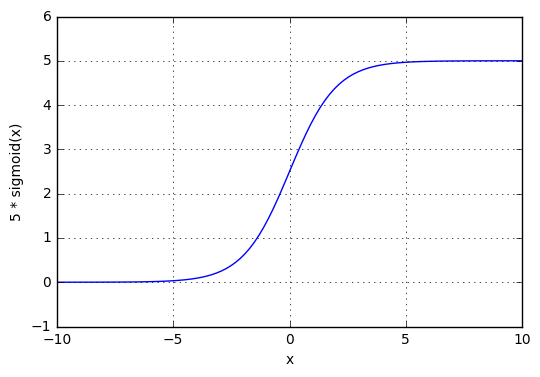

In [9]:
def sigmoid(x):
    """A logistic sigmoid transformation.
    
    Args:
        x (np.ndarrray): A numpy array.
    
    Returns:
        np.ndarray: An array of the same size as x, transformed to the range (0, 1) as:
        
            1 / (1 + exp(-x))
    """
    sigmoid = 1. / (1. + np.exp(-x))
    return sigmoid

x = np.linspace(-10., 10., 100)
y = 5. * sigmoid(x)
plt.plot(x, y)
plt.xlabel('x'); plt.ylabel('5 * sigmoid(x)')
plt.ylim(-1, 6); plt.grid()

In [10]:
def predict_ratings(userfeatures, moviefeatures, userindices, movieindices):
    """Make predictions with a low-rank approximation model.
    
    Args:
        userfeatures (np.ndarray): An n_users x k array, where k is the number of features per user.
        moviefeatures (np.ndarray): An n_movies x k array, where k is the number of features per movie.
        userindices (np.array): An array of user indices to predict ratings for.
        movieindices (np.array): An array of movie indices to predict ratings for.
    
    Returns:
        np.array: For every pair of userindex and movieindex in `userindices` and `movieindes`,
            predicts the rating the corresponding user would give to that movie as the dot product
            between the user features and the movie features:
            
                5 * sigmoid(\sum_i userfeatures[userindex, i] * moviefeatures[movieindex, i])
    """
    dot_product = np.sum(userfeatures[userindices, :] * moviefeatures[movieindices, :], axis=1)
    predicted_ratings = 5. * sigmoid(dot_product)
    return predicted_ratings
    
# Test if our implementation works.
userfeatures = np.array([[1.0, 0.5], [0.0, -2.0]])
moviefeatures = np.array([[1.0, 2.0], [0.5, 1.0]])
userindices = np.array([0, 0, 1, 1])
movieindices = np.array([0, 0, 1, 1])
assert np.all(predict_ratings(userfeatures, moviefeatures, userindices, movieindices) >= 0.)
assert np.all(predict_ratings(userfeatures, moviefeatures, userindices, movieindices) <= 5.)
assert np.all(np.isclose(predict_ratings(userfeatures, moviefeatures, userindices, movieindices), np.array([4.404, 4.404, 0.596, 0.596]), rtol=1e-3))

In [11]:
def loss(weights, userindices=None, movieindices=None, true_ratings=None, regL2=0.):
    """Given the user and movie features, predict the ratings and compare with the true ratings.
    
    Args:
        weights (tuple): The user features and movie features as a tuple of the form (np.ndarray, np.ndarray).
        userindices (np.array): An array of user indices to predict ratings for.
        movieindices (np.array): An array of movie indices to predict ratings for.
        true_ratings (np.array): A numpy array containing the true ratings.
        regL2 (float): The coefficient for the L2 regularization term of the loss function.
    
    Returns:
        np.array: The RMSE between the predicted ratings generated with `predict_ratings`,
            and the given `true_ratings`, summed with regL2 times the L2 norm of the weights:
            
                rmse(predicted_ratings, true_ratings) + regL2 * L2(userfeatures, moviefeatures)
    """
    # Unpack the weights tuple into the user and movie features to pass to `predict_ratings`.
    userfeatures, moviefeatures = weights
    # Predict the ratings.
    predicted_ratings = predict_ratings(userfeatures, moviefeatures, userindices, movieindices)
    # Compute the loss as the RMSE between the predicted and the true ratings,
    # summed with regL2 times the L2 norm of the user- and moviefeatures.
    loss = rmse(predicted_ratings, true_ratings) + regL2 * L2(userfeatures, moviefeatures)
    return loss

# Test if our implementation works.
userfeatures = np.array([[1.0, 0.5], [0.0, -2.0]])
moviefeatures = np.array([[1.0, 2.0], [0.5, 1.0]])
userindices = np.array([0, 0, 1, 1])
movieindices = np.array([0, 0, 1, 1])
true_ratings = np.array([2., 2., -2., 0.])
assert np.isclose(loss((userfeatures, moviefeatures), userindices, movieindices, true_ratings), 2.159, rtol=1e-03)

## 5. Implement a training algorithm

If you made it to here and see no exceptions, good job! In the next cell, we've implemented a variant of a stochastic gradient descent (SGD) algorithm called ADAM that will find the optimal `userfeatures` and `moviefeatures` for us by minimizing the `loss` function.

Every iteration, a slice of a few hundred samples called a mini-batch is taken from `X_train` and `y_train`, generated by `minibatch_indices`. The `minibatch_loss` function passes those on to `loss`, which computes the loss on that mini-batch. The SGD algorithm doesn't actually need to call `minibatch_loss` itself every iteration. Rather, it calls the gradient of `minibatch_loss`, which is computed for us automatically by the autograd package. At every iteration, the (negative of the) gradient points to the direction in which the loss function decreases. Gradient descent algorithms update the solution by taking a small step in that direction every iteration.

In [12]:
def minibatch_indices(it, minibatch_size):
    """Returns a slice of indices given the iteration number."""
    num_batches = int(np.ceil(X_train.shape[0] / minibatch_size))
    it = it % num_batches
    return slice(it * minibatch_size, (it + 1) * minibatch_size)

def minibatch_loss(weights, it, regL2=0., minibatch_size=512):
    """Computes the loss on a slice of training samples generated by `minibatch_indices`."""
    # Get the indices of the samples we want to optimize in this iteration.
    indices = minibatch_indices(it, minibatch_size)
    userindices, movieindices, true_ratings = X_train[indices, 0], X_train[indices, 1], y_train[indices]
    return loss(weights, userindices, movieindices, true_ratings, regL2)

# Define some functions that we can call with our weights
# to evaluate the training, validation and test performance.
from functools import partial
subset = np.random.choice(len(y_train), len(y_validation), replace=False)
full_training_rmse = partial(loss, userindices=X_train[subset, 0], movieindices=X_train[subset, 1], true_ratings=y_train[subset])
full_validation_rmse = partial(loss, userindices=X_validation[:, 0], movieindices=X_validation[:, 1], true_ratings=y_validation)
full_test_rmse = partial(loss, userindices=X_test[:, 0], movieindices=X_test[:, 1], true_ratings=y_test)

def plot_convergence(epochs, training_rmse_log, validation_rmse_log):
    """Plots the convergence of the training and validation RMSE."""
    best = np.argmin(validation_rmse_log)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, training_rmse_log, label='Training RMSE')
    plt.plot(epochs, validation_rmse_log, label='Validation RMSE')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    btm = 0.9 * min(training_rmse_log)
    top = 1.1 * max(training_rmse_log)
    plt.xlim(epochs.min(), epochs.max()); plt.ylim(btm, top)
    plt.plot([epochs[best], epochs[best]], [btm, top])
    plt.xlabel('epoch'); plt.ylabel('RMSE'); plt.grid()
    plt.title('Best validation RMSE is {rmse:.3f} at epoch {epoch:.2f}'.format(
        rmse=validation_rmse_log[best], epoch=epochs[best]))

# The ADAM algorithm adapted from [1] for this tutorial.
# [1] https://github.com/HIPS/autograd/blob/master/autograd/optimizers.py
from autograd.util import flatten_func
from tqdm import trange
def adam(grad, init_params, n_epochs=2., step_size=1e-3,
         b1=0.9, b2=0.999, eps=1e-8, log_steps=100, minibatch_size=512):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf."""
    # Run ADAM for num_iters epochs.
    flattened_grad, unflatten, x = flatten_func(grad, init_params)
    m, v = np.zeros(len(x)), np.zeros(len(x))
    training_rmse_log, validation_rmse_log = [], []
    num_iters = int(np.round(n_epochs * len(y_train) / minibatch_size))
    log_steps = np.round(np.linspace(0, num_iters - 1, min(log_steps, num_iters)))
    best_loss, best_x = np.inf, None
    for i in trange(num_iters, unit='minibatch'):
        g = flattened_grad(x, i)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = x - step_size*mhat/(np.sqrt(vhat) + eps)
        if i in log_steps:
            training_rmse_log.append(full_training_rmse(unflatten(x)))
            validation_rmse_log.append(full_validation_rmse(unflatten(x)))
            if (len(validation_rmse_log) > 1) and (validation_rmse_log[-1] < best_loss):
                best_loss, best_x = validation_rmse_log[-1], x
    # Plot the results on training and validation set.
    epochs = log_steps * minibatch_size / len(y_train)
    plot_convergence(epochs, training_rmse_log, validation_rmse_log)
    return unflatten(best_x)

In [13]:
def train(config, initial_weights=None):
    """Train the LRA model.
    
    Args:
        config (dict): A dictionary of configuration parameters for the model and algorithm.
        initial_weights (tuple): A tuple of the form (np.ndarray, np.ndarray), containing
            the initial userfeatures and moviefeatures to start with, respectively. If None,
            they are initialized with `np.random.randn`.
    
    Returns:
        tuple: A tuple of (userfeatures, moviefeatures) that performed best on the
            validation set during training.
    """
    # Initialize the user features and movie features.
    if initial_weights is None:
        np.random.seed(42)
        initial_weights = (0.1 * np.random.randn(n_users, config['k']),
                           0.1 * np.random.randn(n_movies, config['k']))
    # Configure the mini-batch loss.
    configured_minibatch_loss = partial(
        minibatch_loss,
        regL2=config['regL2'],
        minibatch_size=config['minibatch_size'])
    # Compute the gradient of the mini-batch loss.
    minibatch_loss_gradient = grad(configured_minibatch_loss)
    # Iteratively improve the solution by using the gradient to take a step that improves the loss.
    weights = adam(
        minibatch_loss_gradient,
        initial_weights,
        n_epochs=config['n_epochs'],
        step_size=config['step_size'],
        log_steps=config['log_steps'],
        minibatch_size=config['minibatch_size'])
    return weights

## 6. Train and evaluate the model

The `train` function accepts a `config` dictionary that specifies all of the different parameters of our model and algorithm:

- `k`: the number of features each user and movie are represented by,
- `regL2`: the amount of L2 regularization in the loss function,
- `minibatch_size`: the number of samples taken from the training set to compute the gradient with in every iteration,
- `step_size`: the size of the update added to the solution every iteration,
- `n_epochs`: one iteration updates the solution with a single mini-batch, while the number of epochs represents the number of times the algorithm has gone through the whole training data set to update the solution, and
- `log_steps`: the number of times the validation performance is evaluated during training.

There is also an optional `initial_weights` argument if you want to supply your own initial solution. If it is `None`, the solution is initialized as a tuple `(userfeatures, moviefeatures)` with `np.random.randn`, cf. `train` for details.

The output of `train` is the solution that had the best performance on the validation set during training.

### 6.1 Generating a decent initial solution

We'll first run a few iterations of the algorithm on a randomly initialized solution to obtain a higher quality solution that we can use to jump start our subsequent training steps.

We'll keep iterating through mini-batches of 512 samples until the algorithm has seen half of the training data, which we specify with `n_epochs: 0.5`. This keeps the training time short, and at the same time allows us to set `regL2` to zero, since there is little risk of overfitting the training data if we train for such a short amount of epochs.

Once training the initial solution has completed, answer the following questions:

- Is there a significant difference between training RMSE and validation RMSE?
- What does this tell you about the amount of overfitting of the obtained solution?

100%|█████████████████████████████████████████████████████████████████████████| 781/781 [00:10<00:00, 72.82minibatch/s]


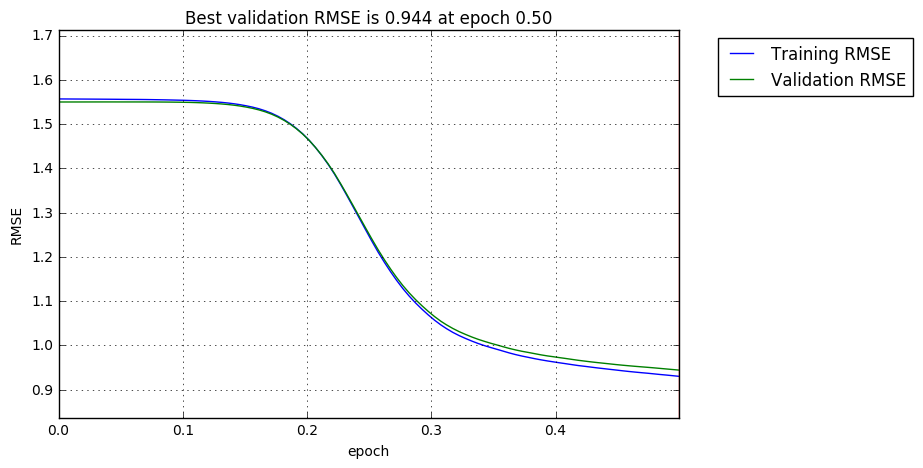

In [14]:
config = {
    'k': 8,
    'regL2': 0.,
    'minibatch_size': 512,
    'step_size': 5e-3,
    'n_epochs': 0.5,
    'log_steps': 100
}
initial_weights = train(config, initial_weights=None)

### 6.2 In search of the best solution

Now we can use the previously obtained `initial_solution` to try and find a better one. Since it was going well, let's first simply increase the number of epochs to 10, so that the training algorithm will have seem the full training set 10 times over.

Once training the initial solution has completed, answer the following questions:

- At what epoch do the training and validation RMSEs achieve their minima?
- What other indicator of overfitting do you observe?
- Try increasing `regL2` to `1e-5` and confirm that this improves both of the above effects. Why does this help?

100%|████████████████████████████████████████████████████████████████████| 15628/15628 [01:48<00:00, 144.17minibatch/s]


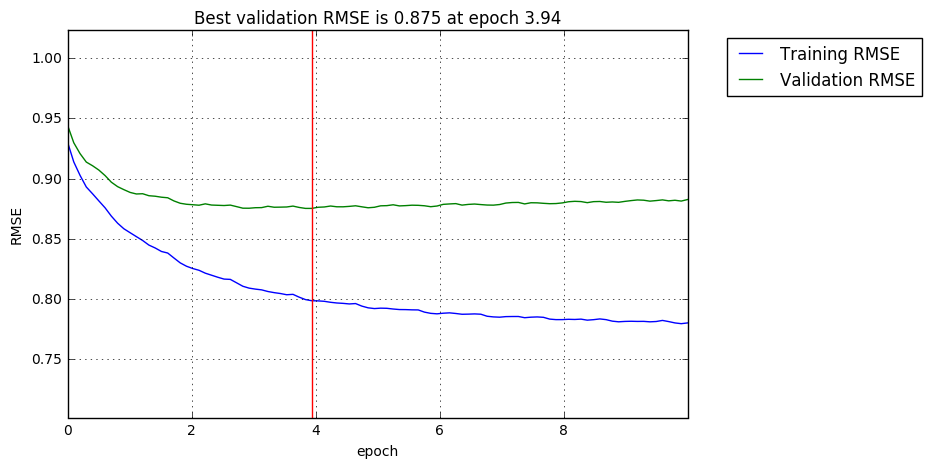

In [15]:
config = {
    'k': 8,
    'regL2': 0.,
    'minibatch_size': 512,
    'step_size': 5e-3,
    'n_epochs': 10.,
    'log_steps': 100
}
weights = train(config, initial_weights=initial_weights)

100%|████████████████████████████████████████████████████████████████████| 15628/15628 [01:52<00:00, 138.78minibatch/s]


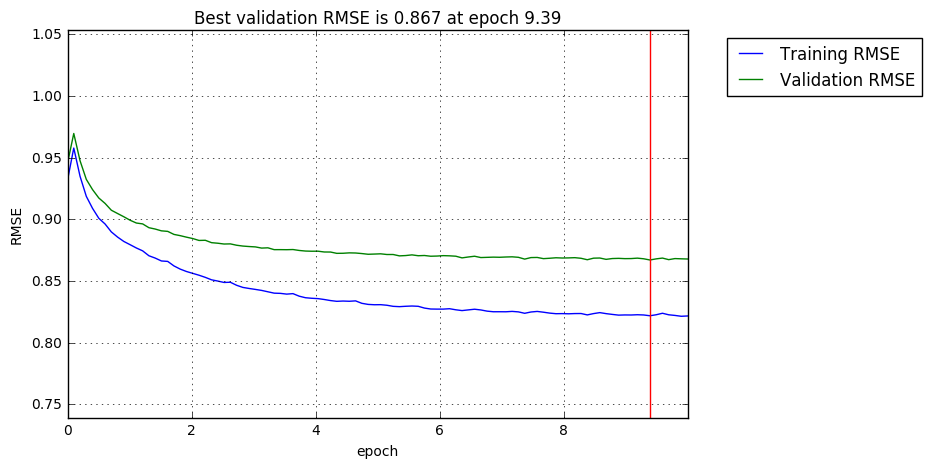

In [16]:
config = {
    'k': 8,
    'regL2': 1e-5,
    'minibatch_size': 512,
    'step_size': 5e-3,
    'n_epochs': 10.,
    'log_steps': 100
}
weights = train(config, initial_weights=initial_weights)

In [18]:
full_test_rmse(weights)

0.86803542513375442

## 7. Where to go from here

The LRA model gets us some pretty nice results, but there are still many opportunities to improve them. Here are some ideas you can try:

- What is the RMSE performance of just using the mean rating per movie as a predictor?
- What is the RMSE performance of just using the mean rating per user as a predictor?
- Some movies get rated consistently lower or higher than others. Similarly, some users consistently rate movies lower or higher than other users. Taking this into account, we could update our model to include these biases by writing: $\hat{r}_{u,i} = p_u + q_i + \sum_{k=1}^K a_{u,k} \cdot b_{i,k}$, where $p_u$ is the user $u$'s bias, and $q_i$ is the movie $i$'s bias. Both the user and movie bias can be initialized neatly using the answers to the previous two questions. How much better does the biased LRA model perform?
- MovieLens also gives us access to each rating's timestamp. We could take time's effect into account in our model in two ways: with a simple time bias, and by adding the effect of time to each of the user and movie features. Combining both effects, our model would be: $\hat{r}_{u,i,t} = p_u + q_i + v_t + \sum_{k=1}^K a_{u,k} \cdot b_{i,k} \cdot c_{t,k}$, where $v_t$ is the bias due to time, and $c_{t,k}$ is the effect of time on the features. Notice that our model $\hat{r}_{u,i,t}$ now allows us to predict ratings for users given to items _at a specific timestamp_! In fact, because of the extra time dimension, we are now looking at a tensor factorization (TF) model. How much better does the biased temporal LRA model perform?
- A known weakness of the LRA model is that it does not perform well on new users and movies, since they have no or few ratings to base the predictions on. A good way to deal with this cold-start problem is to exploit additional information we have available on the users and movies, such as age group, occupancy, genre, director, year, and so on. Incorporating this information in our model can be done elegantly with so-called coupled matrix and tensor factorization, also known as multi-relational learning, and data fusion. A good starting point is Rendle's Factorization Machines paper [1].

[1] http://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf